In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import figure_utils as utils

from truncated_normal import truncated_normal as tn
from scipy.stats import ttest_ind, ranksums, gmean
from sklearn.svm import SVC

%matplotlib inline

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Effect of sample size on rare populations

In [2]:
np.random.seed(0)

nlist = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

d = 500
nY = 100
muL = np.zeros(d)
muL[:10] = -1
muR = np.zeros(d)
muR[:10] = 1
Cov = np.ones(d)

num_sims = 5
picklefile = 'pickled/sim_sample_sweep.pickle'

if os.path.isfile(picklefile):
    sweep_results = pickle.load(open(picklefile, 'rb'))
else:
    sweep_results = {}

start = time.time()
for nZ in nlist:
    for i in range(num_sims):
        print('Simulation %s/%s for nZ = %s (%.2f s elapsed)'\
              %(i+1, num_sims, nZ, time.time()-start))

        if (nZ, i) in sweep_results:
            continue

        _, _, a, b = utils.simulate_hyperplane(muL, muR, Cov, nY, nZ)

        y = utils.truncnormmv(muL, Cov, -a, -b, nY)
        z = utils.truncnormmv(muR, Cov, a, b, nZ)

        p_t = ttest_ind(y, z)[1]
        p_tn = tn.tn_test(y, z, split_prop=0.5, eps=1e-2, verbose=True)

        sweep_results[(nZ, i)] = (p_t, p_tn)

        pickle.dump(sweep_results, open(picklefile, 'wb'))

Simulation 1/5 for nZ = 5 (0.00 s elapsed)
Simulation 2/5 for nZ = 5 (0.00 s elapsed)
Simulation 3/5 for nZ = 5 (0.00 s elapsed)
Simulation 4/5 for nZ = 5 (0.00 s elapsed)
Simulation 5/5 for nZ = 5 (0.00 s elapsed)
Simulation 1/5 for nZ = 10 (0.00 s elapsed)
Simulation 2/5 for nZ = 10 (0.00 s elapsed)
Simulation 3/5 for nZ = 10 (0.00 s elapsed)
Simulation 4/5 for nZ = 10 (0.00 s elapsed)
Simulation 5/5 for nZ = 10 (0.00 s elapsed)
Simulation 1/5 for nZ = 20 (0.00 s elapsed)
Simulation 2/5 for nZ = 20 (0.00 s elapsed)
Simulation 3/5 for nZ = 20 (0.00 s elapsed)
Simulation 4/5 for nZ = 20 (0.00 s elapsed)
Simulation 5/5 for nZ = 20 (0.00 s elapsed)
Simulation 1/5 for nZ = 30 (0.00 s elapsed)
Simulation 2/5 for nZ = 30 (0.00 s elapsed)
Simulation 3/5 for nZ = 30 (0.00 s elapsed)
Simulation 4/5 for nZ = 30 (0.00 s elapsed)
Simulation 5/5 for nZ = 30 (0.00 s elapsed)
Simulation 1/5 for nZ = 40 (0.00 s elapsed)
Simulation 2/5 for nZ = 40 (0.00 s elapsed)
Simulation 3/5 for nZ = 40 (0.00 s el

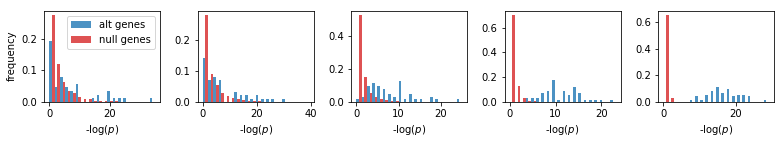

In [3]:
plt.figure(figsize=(11, 2.1))

nlist = [5, 10, 20, 30, 50]

for i, nZ in enumerate(nlist):

    p_t_all = np.array([sweep_results[(nZ, i)][0] for i in range(num_sims)])
    p_tn_all = np.array([sweep_results[(nZ, i)][1] for i in range(num_sims)])

    plt.subplot(1, len(nlist), i+1)
    utils.plot_stacked_hist(-np.log10(p_tn_all[:, :10].reshape(-1)),
                            -np.log10(p_tn_all[:, 10:].reshape(-1)),
                            label=['alt genes', 'null genes'])
#     plt.title('n1 = %s, n2 = %s'%(nZ, nY))
    if i == 0:
        plt.ylabel('frequency')
        plt.legend()
    plt.xlabel(r'-log($p$)')

plt.tight_layout()
plt.savefig('figures/rebuttal_sample_size_TN.pdf',
            format='pdf', dpi=500, bbox_inches='tight')
plt.show()

# Plot of gene inner product w/ hyperplane v amount of selection bias

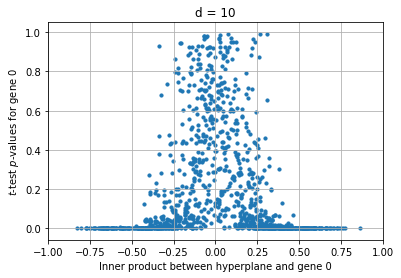

In [4]:
np.random.seed(0)

d = 10
n = 50
num_sims = 1000
b = 0
mu = np.zeros(d)
Cov = np.ones(d)
p = np.zeros(num_sims)
inner_product = np.zeros(num_sims)

for i in range(num_sims):
    a = np.random.normal(0, 1, d)
    a /= np.linalg.norm(a)
    y = utils.truncnormmv(mu, Cov, -a, b, n)
    z = utils.truncnormmv(mu, Cov, a, b, n)
    inner_product[i] = a[0]
    p[i] = ttest_ind(y, z)[1][0]

plt.scatter(inner_product, p, s=10)
plt.xlabel('Inner product between hyperplane and gene 0')
plt.ylabel(r'$t$-test $p$-values for gene 0')
plt.title('d = %s'%(d))
plt.xlim(-1, 1)
plt.grid()
plt.savefig('figures/rebuttal_selection_bias_hyperplane.pdf',
            format='pdf', dpi=500, bbox_inches='tight')
plt.show()

# PBMC gene sets comparison

For number of genes found at various p-value thresholds, and for the proportion of overlap amongst those sets.

In [5]:
# Load data
data_dir = './'
data_R = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_preprocessed.txt'), delimiter=' ')
labels_R = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_labels.txt'), delimiter=' ')
data = np.array(data_R).T
labels = np.array(labels_R).reshape(-1)

tests = [
    "t",
    "wilcox",
    "bimod",
    "tobit",
    "poisson",
    "negbinom",
    "MAST"
]

In [6]:
def load_and_split_data(ident0, ident1, save=True):
    cellsamp1 = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_cellsamp1.txt'%(ident0, ident1)), delimiter=' ')
    pdict = {j:i for i, j in enumerate(data_R.columns)}
    cellsamp_inds = np.array([pdict[i] for i in np.array(cellsamp1).reshape(-1)])
    cellsamp1labels = np.array(pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_cellsamplabels1.txt'%(ident0, ident1)), delimiter=' ')).reshape(-1)

    # get hyperplane using first half of dataset
    svm = SVC(kernel='linear', C=100)
    svm.fit(data[cellsamp_inds], cellsamp1labels)
    a = svm.coef_.reshape(-1)
    b = svm.intercept_[0]
    labels1hat = svm.predict(data[cellsamp_inds])
    print('Consistency of new labels with old: %.3f'\
          %(np.sum(labels1hat == cellsamp1labels)/float(len(cellsamp1labels))))

    # assign points in second half of dataset
    inds = np.ones(len(data)).astype(bool)
    inds[cellsamp_inds] = 0
    for i in np.unique(labels):
        if i != ident0 and i != ident1:
            inds[labels == i] = 0
    labels2 = svm.predict(data[inds])
    y, z = data[inds][labels2 == 0], data[inds][labels2 == 1]

    if save:
        np.savetxt('pbmc_seurat_%sv%s_cellsamp2.txt'%(ident0, ident1), data_R.columns[inds], fmt='%s')
        np.savetxt('pbmc_seurat_%sv%s_cellsamplabels2.txt'%(ident0, ident1), labels2, fmt='%s')
    
    return y, z, a, b


def compare_clusters_tn_test(ident0, ident1):
    """Set up and run TN test data splitting framework"""

    picklefile = 'pbmc_seurat_%sv%s_de_tntest_all_genes.pickle'%(ident0, ident1)
    if os.path.isfile(picklefile):
        return pickle.load(open(picklefile, 'rb'))

    y, z, a, b = load_and_split_data(ident0, ident1)

    # Run TN test on genes that actually change across the two clusters
    keep_inds = np.var(np.vstack((y, z)), 0) > 0
    np.savetxt('pbmc_seurat_%sv%s_filtered_genes.txt'%(ident0, ident1), keep_inds)
    y = y[:, keep_inds]
    z = z[:, keep_inds]
    a = a[keep_inds]
    
    # Get seed based on previous experiment
    seedfile = 'pbmc_seurat_%sv%s_de_tntest_multiple_runs_max_withseed.pickle'%(ident0, ident1)
    tn_test_multiple_runs = pickle.load(open(seedfile, 'rb'))
    _, _, seed = sorted(tn_test_multiple_runs, key = lambda x:x[1])[-1]
    np.random.set_state(seed)

    # Run TN test multiple times to evaluate stability
    p_tn, likelihood = tn.tn_test(y, z, a=a, b=b, verbose=True, learning_rate=0.5,
                                  eps=1e-1, return_likelihood=True, num_iters=10000, num_cores=64)
    pickle.dump(p_tn, open(picklefile, 'wb'))

    return p_tn, likelihood[-1]


def match_vectors(v_in, v_target):
    d = {entry:i for i, entry in enumerate(v_in)}
    return np.array([d[entry] for entry in v_target])


def jaccard_similarity(v1, v2):
    a = np.intersect1d(v1, v2)
    b = np.union1d(v1, v2)
    return len(a)/len(b)


def make_permutation_matrix(a, b, n=10):
    d = {element:i for i, element in enumerate(b)}
    M = np.zeros((n, n))
    for i, element in enumerate(a):
        if element in d:
            M[i][d[element]] = 1
            
    x_mark_red = b[np.sum(M, 0) == 0]
    y_mark_red = a[np.sum(M, 1) == 0]

    sb.set(font_scale=1.4)
    sb.heatmap(1-M, xticklabels=b, yticklabels=a, cbar=False, square=True)
    for ticklabel in plt.gca().get_xticklabels():
        if ticklabel.get_text() in x_mark_red:
            ticklabel.set_color('r')
    for ticklabel in plt.gca().get_yticklabels():
        if ticklabel.get_text() in y_mark_red:
            ticklabel.set_color('r') 

In [7]:
np.random.seed(0)
ident0, ident1 = 0, 1 # Can also try (1, 3) and (2, 5)

# Get TN test results
p_tn = compare_clusters_tn_test(ident0, ident1)
filename = 'pbmc_seurat_%sv%s_filtered_genes.txt'%(ident0, ident1)
genes_tn = np.array(data_R.index)[np.loadtxt(filename).astype(bool)]

# Get other test results
alphas = np.logspace(-20, -5, 20)
setsizes = np.logspace(0, 3, 9).astype(int)
num_genes_tests = {}
gene_sets_tests = {}
gene_sets_tests_fixedsize = {}
for j, test in enumerate(tests):
    seurat_de = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_de_%s_all_genes.txt'
                                             %(ident0, ident1, test)), delimiter=' ')
    p_test = np.array(seurat_de['p_val'])
    genes_test = seurat_de.index

    # Match gene order for p_tn and p
    gene_list = np.intersect1d(genes_tn, genes_test)
    ind = match_vectors(genes_tn, gene_list)
    genes_tn, p_tn = genes_tn[ind], p_tn[ind]
    ind = match_vectors(genes_test, gene_list)
    genes_test, p_test = genes_test[ind], p_test[ind]
    
    # Get number of genes for various p value thresholds
    if j == 0:
        num_genes_tn = np.zeros(len(alphas))
    num_genes_test = np.zeros(len(alphas))
    for i, alpha in enumerate(alphas):
        if j == 0:
            num_genes_tn[i] = np.sum(p_tn <= alpha)
        num_genes_test[i] = np.sum(p_test <= alpha)
    num_genes_tests[test] = num_genes_test
    
    # Get similarity of sets for various p value thresholds
    if j == 0:
        gene_sets_tn = []
    gene_sets_test = []
    for i, alpha in enumerate(alphas):
        if j == 0:
            gene_sets_tn.append(gene_list[p_tn <= alpha])
        gene_sets_test.append(gene_list[p_test <= alpha])
    gene_sets_tests[test] = gene_sets_test
    
    # Get similarity of sets for various gene set sizes
    if j == 0:
        gene_sets_tn_fixedsize = []
    gene_sets_test_fixedsize = []
    for i, setsize in enumerate(setsizes):
        if j == 0:
            gene_sets_tn_fixedsize.append(gene_list[np.argsort(p_tn)[:setsize]])
        gene_sets_test_fixedsize.append(gene_list[np.argsort(p_test)[:setsize]])
    gene_sets_tests_fixedsize[test] = gene_sets_test_fixedsize

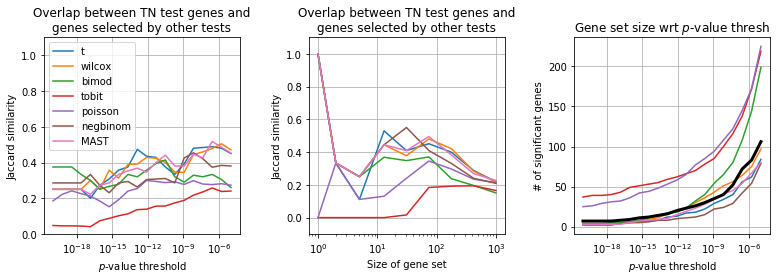

In [8]:
plt.figure(figsize=(11, 4))

plt.subplot(1, 3, 1)
for test in tests:
    overlap = np.zeros(len(alphas))
    for i, alpha in enumerate(alphas):
        overlap[i] = jaccard_similarity(gene_sets_tests[test][i], gene_sets_tn[i])
    plt.plot(alphas, overlap, label=test)
plt.xscale('log')
plt.ylim(0, 1.1)
plt.xlabel(r'$p$-value threshold')
plt.ylabel('Jaccard similarity')
plt.title('Overlap between TN test genes and\ngenes selected by other tests')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
for j, test in enumerate(tests):
    overlap = np.zeros(len(setsizes))
    for i, setsize in enumerate(setsizes):
        overlap[i] = jaccard_similarity(gene_sets_tests_fixedsize[test][i],
                                        gene_sets_tn_fixedsize[i])
    plt.plot(setsizes, overlap, label=test)
plt.xscale('log')
plt.ylim(-0.1, 1.1)
plt.xlabel(r'Size of gene set')
plt.ylabel('Jaccard similarity')
plt.title('Overlap between TN test genes and\ngenes selected by other tests')
plt.grid()

plt.subplot(1, 3, 3)
for test in tests:
    num_genes_test = num_genes_tests[test]
    plt.plot(alphas, num_genes_test, label=test)
plt.plot(alphas, num_genes_tn, label='TN test', c='k', lw=3)
plt.xscale('log')
plt.xlabel(r'$p$-value threshold')
plt.ylabel('# of significant genes')
plt.title(r'Gene set size wrt $p$-value thresh')
plt.grid()

plt.tight_layout()
plt.savefig('figures/rebuttal_gene_set_size_and_overlap.pdf',
            format='pdf', dpi=500, bbox_inches='tight')
plt.show()

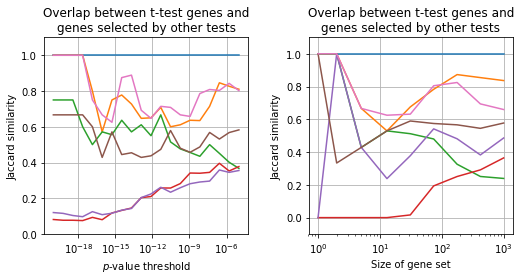

In [9]:
plt.figure(figsize=(11, 4))

plt.subplot(1, 3, 1)
for test in tests:
    overlap = np.zeros(len(alphas))
    for i, alpha in enumerate(alphas):
        overlap[i] = jaccard_similarity(gene_sets_tests[test][i], gene_sets_tests['t'][i])
    plt.plot(alphas, overlap, label=test)
plt.xscale('log')
plt.ylim(0, 1.1)
plt.xlabel(r'$p$-value threshold')
plt.ylabel('Jaccard similarity')
plt.title('Overlap between t-test genes and\ngenes selected by other tests')
plt.grid()

plt.subplot(1, 3, 2)
for j, test in enumerate(tests):
    overlap = np.zeros(len(setsizes))
    for i, setsize in enumerate(setsizes):
        overlap[i] = jaccard_similarity(gene_sets_tests_fixedsize[test][i],
                                        gene_sets_tests_fixedsize['t'][i])
    plt.plot(setsizes, overlap, label=test)
plt.xscale('log')
plt.ylim(-0.1, 1.1)
plt.xlabel(r'Size of gene set')
plt.ylabel('Jaccard similarity')
plt.title('Overlap between t-test genes and\ngenes selected by other tests')
plt.grid()

plt.tight_layout()
plt.savefig('figures/rebuttal_gene_set_size_and_overlap_t.pdf',
            format='pdf', dpi=500, bbox_inches='tight')
plt.show()

# Data-splitting v TN test

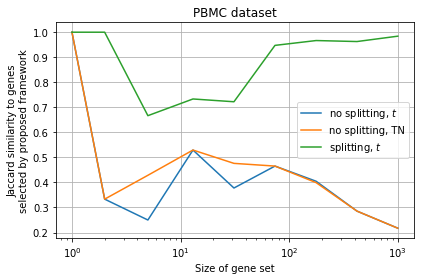

In [10]:
picklefile = 'pickled/pbmc_selectionbias.pickle'
ident0, ident1 = 0, 1

if os.path.isfile(picklefile):
    p_t, p_tn, p_t_split, p_tn_split = pickle.load(open(picklefile, 'rb'))
    
else:
    np.random.seed(0)
    
    cellsamp1 = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_cellsamp1.txt'%(ident0, ident1)), delimiter=' ')
    pdict = {j:i for i, j in enumerate(data_R.columns)}
    cellsamp_inds = np.array([pdict[i] for i in np.array(cellsamp1).reshape(-1)])
    cellsamp1labels = np.array(pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_cellsamplabels1.txt'%(ident0, ident1)), delimiter=' ')).reshape(-1)

    # get hyperplane using first half of dataset
    svm = SVC(kernel='linear', C=100)
    svm.fit(data[cellsamp_inds], cellsamp1labels)
    a = svm.coef_.reshape(-1)
    b = svm.intercept_[0]
    labels1hat = svm.predict(data[cellsamp_inds])
    print('Consistency of new labels with old: %.3f'\
          %(np.sum(labels1hat == cellsamp1labels)/float(len(cellsamp1labels))))
    
    # label second half of dataset
    inds = np.ones(len(data)).astype(bool)
    inds[cellsamp_inds] = 0
    for i in np.unique(labels):
        if i != ident0 and i != ident1:
            inds[labels == i] = 0
    labels2 = svm.predict(data[inds]) 

    # Situations 1 and 2: no split
    y = data[cellsamp_inds][cellsamp1labels == 0]
    z = data[cellsamp_inds][cellsamp1labels == 1]
    p_t = ttest_ind(y, z)[1]
    p_tn = tn.tn_test(y, z, a=a, b=b, verbose=True, learning_rate=0.5,
                        eps=1e-1, return_likelihood=False, num_iters=10000, num_cores=64)

    # Situations 3 and 4: split
    y = data[inds][labels2 == 0]
    z = data[inds][labels2 == 1]
    p_t_split = ttest_ind(y, z)[1]
    p_tn_split = compare_clusters_tn_test(ident0, ident1)

    pickle.dump((p_t, p_tn, p_t_split, p_tn_split), open(picklefile, 'wb'))
    
    
genes1 = np.array(data_R.index)
filename = 'pbmc_seurat_%sv%s_filtered_genes.txt'%(ident0, ident1)
genes2 = genes1[np.loadtxt(filename).astype(bool)]

g1v2 = np.zeros(len(setsizes))
g1v3 = np.zeros(len(setsizes))
g1v4 = np.zeros(len(setsizes))

g4v1 = np.zeros(len(setsizes))
g4v2 = np.zeros(len(setsizes))
g4v3 = np.zeros(len(setsizes))

for i, setsize in enumerate(setsizes):
    
    g1 = genes1[np.argsort(p_t)[:setsize]]
    g2 = genes1[np.argsort(p_tn)[:setsize]]
    g3 = genes1[np.argsort(p_t_split)[:setsize]]
    g4 = genes2[np.argsort(p_tn_split)[:setsize]]
    
    # assuming g1 is truth
    g1v2[i] = jaccard_similarity(g1, g2)
    g1v3[i] = jaccard_similarity(g1, g3)
    g1v4[i] = jaccard_similarity(g1, g4)

    # assuming g4 is truth
    g4v1[i] = jaccard_similarity(g4, g1)
    g4v2[i] = jaccard_similarity(g4, g2)
    g4v3[i] = jaccard_similarity(g4, g3)

plt.plot(setsizes, g4v1, label=r'no splitting, $t$')
plt.plot(setsizes, g4v2, label='no splitting, TN')
plt.plot(setsizes, g4v3, label=r'splitting, $t$')
plt.grid()
plt.xscale('log')
plt.xlabel('Size of gene set')
plt.ylabel('Jaccard similarity to genes\nselected by proposed framework')
plt.title('PBMC dataset')
plt.legend()

plt.tight_layout()
plt.savefig('figures/rebuttal_selection_bias.pdf',
            format='pdf', dpi=500, bbox_inches='tight')
plt.show()

# Permutation matrix for gene rankings

# genes in both sets: 64


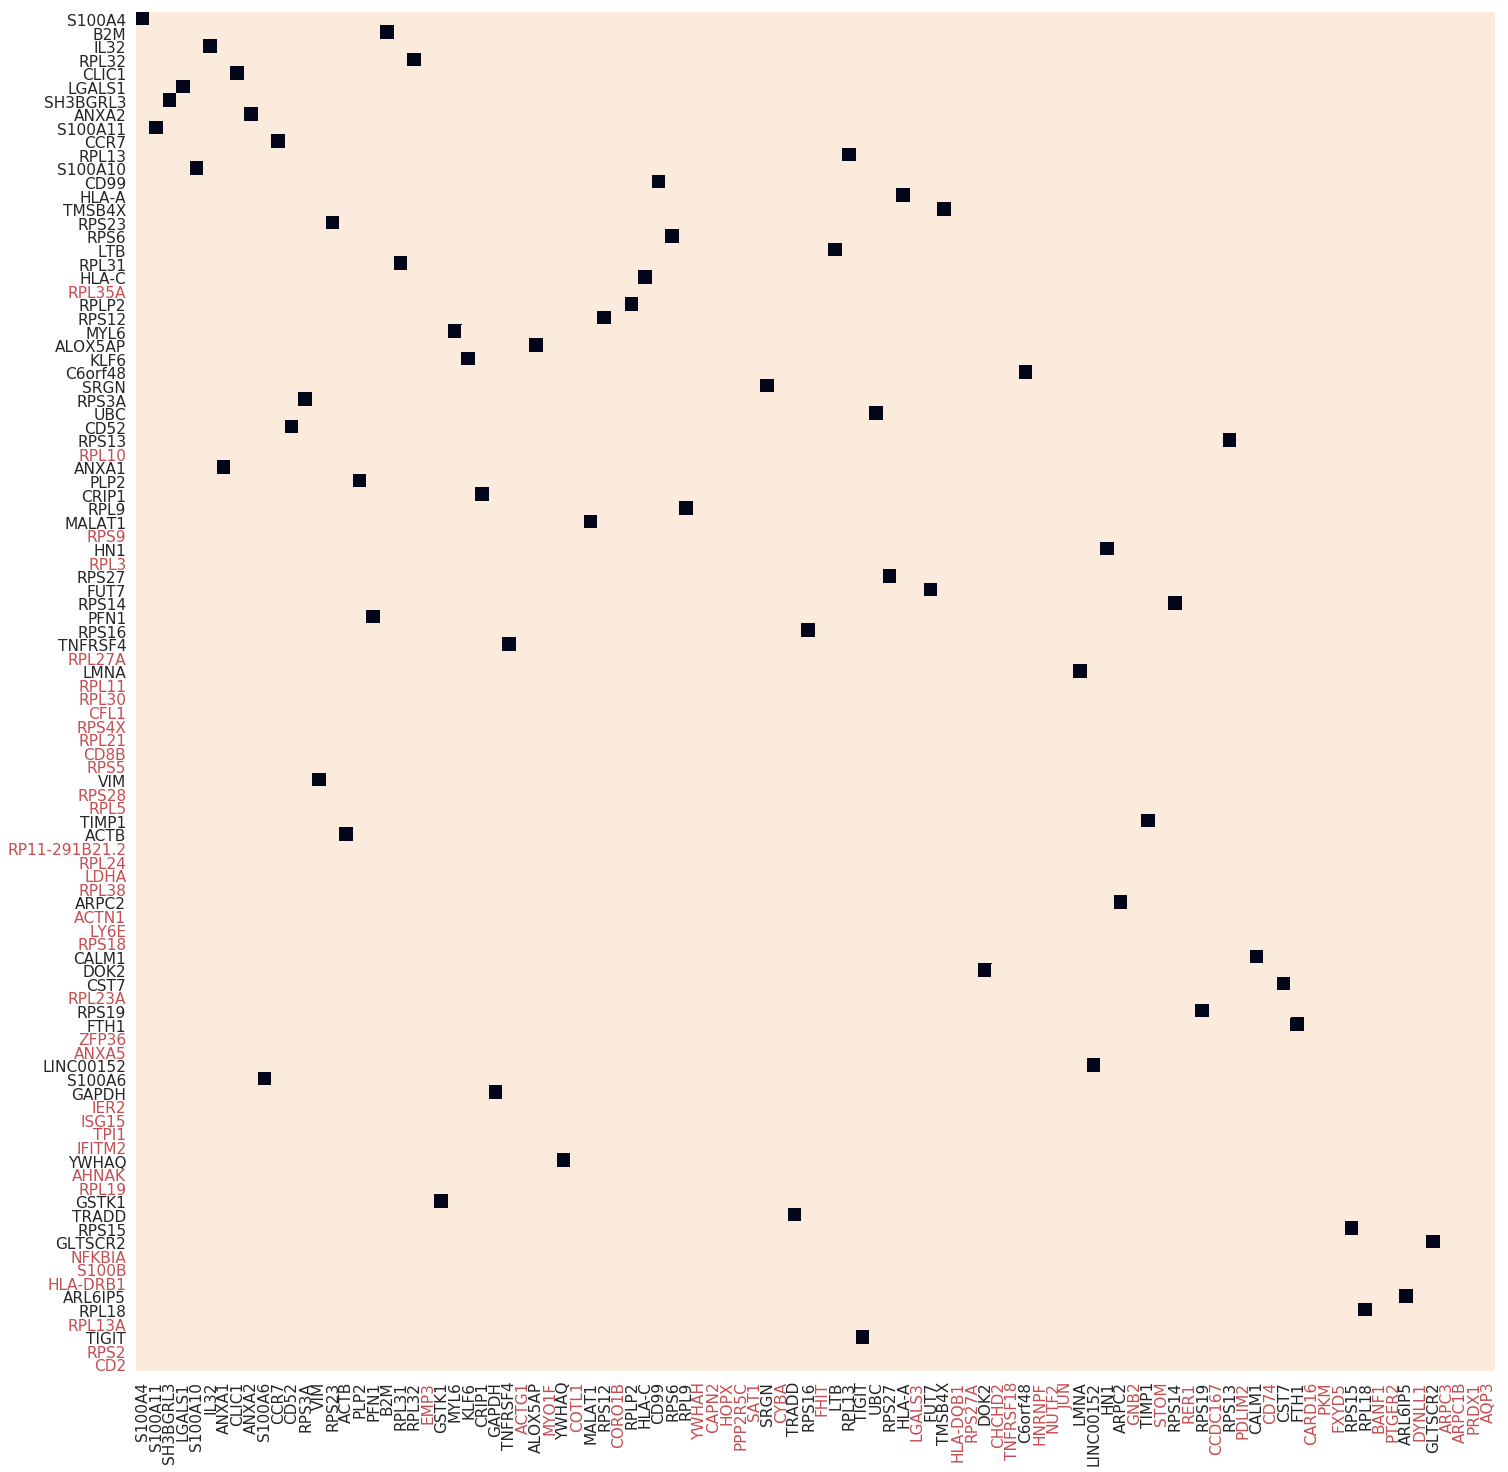

In [11]:
np.random.seed(0)
ident0, ident1 = 0, 1 # Can also try (1, 3) and (2, 5)

# Get TN test results
p_tn = compare_clusters_tn_test(ident0, ident1)
filename = 'pbmc_seurat_%sv%s_filtered_genes.txt'%(ident0, ident1)
genes_tn = np.array(data_R.index)[np.loadtxt(filename).astype(bool)]

# Get other test results
test = 't'
seurat_de = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_de_%s_all_genes.txt'
                                         %(ident0, ident1, test)), delimiter=' ')
p_test = np.array(seurat_de['p_val'])
genes_test = seurat_de.index

# Match gene order for p_tn and p
gene_list = np.intersect1d(genes_tn, genes_test)
ind = match_vectors(genes_tn, gene_list)
genes_tn, p_tn = genes_tn[ind], p_tn[ind]
ind = match_vectors(genes_test, gene_list)
genes_test, p_test = genes_test[ind], p_test[ind]

# Permutation matrix
n = 100
a = gene_list[np.argsort(p_test)[:n]]
b = gene_list[np.argsort(p_tn)[:n]]
print('# genes in both sets: %s'%(len(np.intersect1d(a, b))))
plt.figure(figsize=(25, 25))
make_permutation_matrix(a, b, n=n)
plt.savefig('figures/rebuttal_permutation_matrix.pdf',
            format='pdf', dpi=500, bbox_inches='tight')